In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=False
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=1939 #Number of units in hidden layer 1
# hidden2=2048 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
# fc_dim1=128
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2048
# clf_hidden=256

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=100
# clfweight=20
# randFeatureSubset=None
model_str='fc1'
clf=None
training_samples='control13'
training_sample_X='logminmax'
standardizeX=False
name='c13k20XAlogminmax_FCXonly_01_dropout'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
#     featureslist={}
#     featureslist['disease13X_corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9494'])
#     featureslist['control13X_corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9498'])
#     featureslist['disease8X_corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9723'])
#     featureslist['control8X_corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9735'])
#     featureslist['disease13X_scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9494'])
#     featureslist['control13X_scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9498'])
#     featureslist['disease8X_scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9723'])
#     featureslist['control8X_scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9735'])
    
    features=scaleddata.layers[training_sample_X][scaleddata.obs['sample']==sampleidx[training_samples]]
    features=torch.tensor(features)
    

else:
    featureraw=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    featureraw_train=featureraw.X[featureraw.obs['sample']==sampleidx[training_samples]]
    
    if training_sample_X=='logminmax':
        featurelog_train=np.log2(featureraw_train+1/2)
        scaler = MinMaxScaler()
        featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
        features=torch.tensor(featurelog_train_minmax)



if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    


adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adj_train=adj_list[training_samples]

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
maskpath=os.path.join(savedir,'trainMask',training_samples+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
if useSavedMaskedEdges and os.path.exists(maskpath):
    print('opening saved')
    with open(maskpath, 'rb') as input:
        maskedgeres = pickle.load(input)
else:
    # construct training, validation, and test sets
    maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
    with open(maskpath, 'wb') as output:
        pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)


In [5]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [6]:
# loop over all train/validation sets
train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres

adj_norm = preprocessing.preprocess_graph(adj_train)
adj_label=adj_train + sp.eye(adj_train.shape[0])
adj_label=torch.tensor(adj_label.todense())

num_nodes,num_features = features.shape

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model  = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model  = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model  = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model  = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model  = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model  = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model  = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model  = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model  = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model  = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model  = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model  = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
pos_weight = float(adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) / adj_train.sum() #using full unmasked adj
pos_weight=torch.tensor(pos_weight)
norm = adj_train.shape[0] * adj_train.shape[0] / float((adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) * 2)

if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    features = features.cuda().float()
    adj_norm=adj_norm.cuda()
    adj_label = adj_label.cuda().float()
    train_nodes_idx=train_nodes_idx.cuda()
    val_nodes_idx=val_nodes_idx.cuda()
    test_nodes_idx=test_nodes_idx.cuda()

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:

 
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()

    adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
#     features_recon, z, mu, logvar=model(features.float())
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
        
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
#     loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
#     loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
    loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
#         features_recon, z, mu, logvar=model(features.float())
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)

    loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
#     loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
#     loss_val = loss_x_val+loss_a_val
    loss_val=loss_x_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    
#     print(features_recon[:5,:5])
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
#           'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
#           'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    else:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item()

# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
t_ep=time.time()
for ep in range(epochs):
#     train_loss_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep]=train(ep)
    train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep]=train(ep)
#     if clf:
#         train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
#     else:
#         train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print('total time: {:.4f}s'.format(time.time() - t_ep))


Epoch: 0000 loss_train: 35.1349 loss_kl_train: 0.2265 loss_x_train: 34.9085 loss_val: 1.8071 loss_x_val: 1.8071 time: 0.3486s
Epoch: 0001 loss_train: 29.4378 loss_kl_train: 0.1977 loss_x_train: 29.2401 loss_val: 1.7535 loss_x_val: 1.7535 time: 0.2153s
Epoch: 0002 loss_train: 5.9661 loss_kl_train: 0.1807 loss_x_train: 5.7854 loss_val: 1.7402 loss_x_val: 1.7402 time: 0.2138s
Epoch: 0003 loss_train: 2.0286 loss_kl_train: 0.1671 loss_x_train: 1.8614 loss_val: 1.8146 loss_x_val: 1.8146 time: 0.2138s
Epoch: 0004 loss_train: 1.9848 loss_kl_train: 0.1584 loss_x_train: 1.8264 loss_val: 1.8277 loss_x_val: 1.8277 time: 0.2155s
Epoch: 0005 loss_train: 1.9748 loss_kl_train: 0.1520 loss_x_train: 1.8227 loss_val: 1.8267 loss_x_val: 1.8267 time: 0.2157s
Epoch: 0006 loss_train: 1.9664 loss_kl_train: 0.1471 loss_x_train: 1.8193 loss_val: 1.8229 loss_x_val: 1.8229 time: 0.2139s
Epoch: 0007 loss_train: 1.9558 loss_kl_train: 0.1433 loss_x_train: 1.8125 loss_val: 1.8173 loss_x_val: 1.8173 time: 0.2163s
Epoc

Epoch: 0067 loss_train: 1.7141 loss_kl_train: 0.0924 loss_x_train: 1.6217 loss_val: 1.6287 loss_x_val: 1.6287 time: 0.2176s
Epoch: 0068 loss_train: 1.7116 loss_kl_train: 0.0920 loss_x_train: 1.6196 loss_val: 1.6273 loss_x_val: 1.6273 time: 0.2145s
Epoch: 0069 loss_train: 1.7092 loss_kl_train: 0.0916 loss_x_train: 1.6176 loss_val: 1.6258 loss_x_val: 1.6258 time: 0.2161s
Epoch: 0070 loss_train: 1.7067 loss_kl_train: 0.0911 loss_x_train: 1.6156 loss_val: 1.6242 loss_x_val: 1.6242 time: 0.2163s
Epoch: 0071 loss_train: 1.7045 loss_kl_train: 0.0908 loss_x_train: 1.6138 loss_val: 1.6226 loss_x_val: 1.6226 time: 0.2166s
Epoch: 0072 loss_train: 1.7022 loss_kl_train: 0.0903 loss_x_train: 1.6118 loss_val: 1.6209 loss_x_val: 1.6209 time: 0.2173s
Epoch: 0073 loss_train: 1.7012 loss_kl_train: 0.0899 loss_x_train: 1.6112 loss_val: 1.6190 loss_x_val: 1.6190 time: 0.2155s
Epoch: 0074 loss_train: 1.6976 loss_kl_train: 0.0894 loss_x_train: 1.6082 loss_val: 1.6174 loss_x_val: 1.6174 time: 0.2155s
Epoch: 0

Epoch: 0134 loss_train: 1.6083 loss_kl_train: 0.0689 loss_x_train: 1.5394 loss_val: 1.5491 loss_x_val: 1.5491 time: 0.2168s
Epoch: 0135 loss_train: 1.6071 loss_kl_train: 0.0685 loss_x_train: 1.5386 loss_val: 1.5484 loss_x_val: 1.5484 time: 0.2148s
Epoch: 0136 loss_train: 1.6059 loss_kl_train: 0.0683 loss_x_train: 1.5377 loss_val: 1.5477 loss_x_val: 1.5477 time: 0.2177s
Epoch: 0137 loss_train: 1.6096 loss_kl_train: 0.0680 loss_x_train: 1.5416 loss_val: 1.5469 loss_x_val: 1.5469 time: 0.2170s
Epoch: 0138 loss_train: 1.6037 loss_kl_train: 0.0677 loss_x_train: 1.5360 loss_val: 1.5462 loss_x_val: 1.5462 time: 0.2162s
Epoch: 0139 loss_train: 1.6027 loss_kl_train: 0.0675 loss_x_train: 1.5352 loss_val: 1.5454 loss_x_val: 1.5454 time: 0.2175s
Epoch: 0140 loss_train: 1.6069 loss_kl_train: 0.0672 loss_x_train: 1.5397 loss_val: 1.5446 loss_x_val: 1.5446 time: 0.2172s
Epoch: 0141 loss_train: 1.6059 loss_kl_train: 0.0669 loss_x_train: 1.5390 loss_val: 1.5438 loss_x_val: 1.5438 time: 0.2156s
Epoch: 0

Epoch: 0201 loss_train: 1.5549 loss_kl_train: 0.0530 loss_x_train: 1.5019 loss_val: 1.5106 loss_x_val: 1.5106 time: 0.2167s
Epoch: 0202 loss_train: 1.5541 loss_kl_train: 0.0528 loss_x_train: 1.5013 loss_val: 1.5102 loss_x_val: 1.5102 time: 0.2188s
Epoch: 0203 loss_train: 1.5532 loss_kl_train: 0.0526 loss_x_train: 1.5006 loss_val: 1.5098 loss_x_val: 1.5098 time: 0.2158s
Epoch: 0204 loss_train: 1.5556 loss_kl_train: 0.0524 loss_x_train: 1.5032 loss_val: 1.5094 loss_x_val: 1.5094 time: 0.2167s
Epoch: 0205 loss_train: 1.5516 loss_kl_train: 0.0522 loss_x_train: 1.4994 loss_val: 1.5090 loss_x_val: 1.5090 time: 0.2180s
Epoch: 0206 loss_train: 1.5509 loss_kl_train: 0.0520 loss_x_train: 1.4989 loss_val: 1.5086 loss_x_val: 1.5086 time: 0.2172s
Epoch: 0207 loss_train: 1.5548 loss_kl_train: 0.0518 loss_x_train: 1.5030 loss_val: 1.5083 loss_x_val: 1.5083 time: 0.2153s
Epoch: 0208 loss_train: 1.5543 loss_kl_train: 0.0516 loss_x_train: 1.5027 loss_val: 1.5080 loss_x_val: 1.5080 time: 0.2183s
Epoch: 0

Epoch: 0268 loss_train: 1.5261 loss_kl_train: 0.0418 loss_x_train: 1.4843 loss_val: 1.4903 loss_x_val: 1.4903 time: 0.2180s
Epoch: 0269 loss_train: 1.5213 loss_kl_train: 0.0416 loss_x_train: 1.4797 loss_val: 1.4898 loss_x_val: 1.4898 time: 0.2180s
Epoch: 0270 loss_train: 1.5211 loss_kl_train: 0.0415 loss_x_train: 1.4796 loss_val: 1.4895 loss_x_val: 1.4895 time: 0.2155s
Epoch: 0271 loss_train: 1.5208 loss_kl_train: 0.0414 loss_x_train: 1.4794 loss_val: 1.4890 loss_x_val: 1.4890 time: 0.2159s
Epoch: 0272 loss_train: 1.5205 loss_kl_train: 0.0413 loss_x_train: 1.4792 loss_val: 1.4887 loss_x_val: 1.4887 time: 0.2155s
Epoch: 0273 loss_train: 1.5235 loss_kl_train: 0.0411 loss_x_train: 1.4824 loss_val: 1.4886 loss_x_val: 1.4886 time: 0.2188s
Epoch: 0274 loss_train: 1.5197 loss_kl_train: 0.0409 loss_x_train: 1.4788 loss_val: 1.4883 loss_x_val: 1.4883 time: 0.2170s
Epoch: 0275 loss_train: 1.5194 loss_kl_train: 0.0408 loss_x_train: 1.4786 loss_val: 1.4880 loss_x_val: 1.4880 time: 0.2162s
Epoch: 0

Epoch: 0335 loss_train: 1.5045 loss_kl_train: 0.0337 loss_x_train: 1.4708 loss_val: 1.4773 loss_x_val: 1.4773 time: 0.2159s
Epoch: 0336 loss_train: 1.5042 loss_kl_train: 0.0336 loss_x_train: 1.4707 loss_val: 1.4772 loss_x_val: 1.4772 time: 0.2193s
Epoch: 0337 loss_train: 1.5039 loss_kl_train: 0.0334 loss_x_train: 1.4705 loss_val: 1.4771 loss_x_val: 1.4771 time: 0.2186s
Epoch: 0338 loss_train: 1.5035 loss_kl_train: 0.0334 loss_x_train: 1.4701 loss_val: 1.4771 loss_x_val: 1.4771 time: 0.2164s
Epoch: 0339 loss_train: 1.5013 loss_kl_train: 0.0333 loss_x_train: 1.4681 loss_val: 1.4768 loss_x_val: 1.4768 time: 0.2172s
Epoch: 0340 loss_train: 1.5026 loss_kl_train: 0.0332 loss_x_train: 1.4695 loss_val: 1.4767 loss_x_val: 1.4767 time: 0.2181s
Epoch: 0341 loss_train: 1.5022 loss_kl_train: 0.0331 loss_x_train: 1.4691 loss_val: 1.4766 loss_x_val: 1.4766 time: 0.2179s
Epoch: 0342 loss_train: 1.5017 loss_kl_train: 0.0330 loss_x_train: 1.4687 loss_val: 1.4765 loss_x_val: 1.4765 time: 0.2178s
Epoch: 0

Epoch: 0402 loss_train: 1.4891 loss_kl_train: 0.0276 loss_x_train: 1.4615 loss_val: 1.4700 loss_x_val: 1.4700 time: 0.2169s
Epoch: 0403 loss_train: 1.4905 loss_kl_train: 0.0276 loss_x_train: 1.4629 loss_val: 1.4700 loss_x_val: 1.4700 time: 0.2174s
Epoch: 0404 loss_train: 1.4904 loss_kl_train: 0.0275 loss_x_train: 1.4629 loss_val: 1.4699 loss_x_val: 1.4699 time: 0.2181s
Epoch: 0405 loss_train: 1.4902 loss_kl_train: 0.0274 loss_x_train: 1.4628 loss_val: 1.4699 loss_x_val: 1.4699 time: 0.2179s
Epoch: 0406 loss_train: 1.4899 loss_kl_train: 0.0273 loss_x_train: 1.4626 loss_val: 1.4698 loss_x_val: 1.4698 time: 0.2171s
Epoch: 0407 loss_train: 1.4895 loss_kl_train: 0.0272 loss_x_train: 1.4623 loss_val: 1.4697 loss_x_val: 1.4697 time: 0.2184s
Epoch: 0408 loss_train: 1.4885 loss_kl_train: 0.0272 loss_x_train: 1.4613 loss_val: 1.4696 loss_x_val: 1.4696 time: 0.2186s
Epoch: 0409 loss_train: 1.4885 loss_kl_train: 0.0271 loss_x_train: 1.4614 loss_val: 1.4695 loss_x_val: 1.4695 time: 0.2161s
Epoch: 0

Epoch: 0469 loss_train: 1.4801 loss_kl_train: 0.0230 loss_x_train: 1.4571 loss_val: 1.4657 loss_x_val: 1.4657 time: 0.2166s
Epoch: 0470 loss_train: 1.4812 loss_kl_train: 0.0229 loss_x_train: 1.4582 loss_val: 1.4657 loss_x_val: 1.4657 time: 0.2187s
Epoch: 0471 loss_train: 1.4809 loss_kl_train: 0.0229 loss_x_train: 1.4580 loss_val: 1.4656 loss_x_val: 1.4656 time: 0.2172s
Epoch: 0472 loss_train: 1.4802 loss_kl_train: 0.0228 loss_x_train: 1.4573 loss_val: 1.4655 loss_x_val: 1.4655 time: 0.2179s
Epoch: 0473 loss_train: 1.4802 loss_kl_train: 0.0228 loss_x_train: 1.4574 loss_val: 1.4654 loss_x_val: 1.4654 time: 0.2166s
Epoch: 0474 loss_train: 1.4801 loss_kl_train: 0.0227 loss_x_train: 1.4574 loss_val: 1.4654 loss_x_val: 1.4654 time: 0.2175s
Epoch: 0475 loss_train: 1.4802 loss_kl_train: 0.0227 loss_x_train: 1.4575 loss_val: 1.4653 loss_x_val: 1.4653 time: 0.2183s
Epoch: 0476 loss_train: 1.4798 loss_kl_train: 0.0226 loss_x_train: 1.4572 loss_val: 1.4653 loss_x_val: 1.4653 time: 0.2179s
Epoch: 0

Epoch: 0536 loss_train: 1.4723 loss_kl_train: 0.0194 loss_x_train: 1.4529 loss_val: 1.4629 loss_x_val: 1.4629 time: 0.2162s
Epoch: 0537 loss_train: 1.4722 loss_kl_train: 0.0194 loss_x_train: 1.4528 loss_val: 1.4629 loss_x_val: 1.4629 time: 0.2189s
Epoch: 0538 loss_train: 1.4775 loss_kl_train: 0.0194 loss_x_train: 1.4581 loss_val: 1.4630 loss_x_val: 1.4630 time: 0.2181s
Epoch: 0539 loss_train: 1.4719 loss_kl_train: 0.0193 loss_x_train: 1.4526 loss_val: 1.4630 loss_x_val: 1.4630 time: 0.2165s
Epoch: 0540 loss_train: 1.4718 loss_kl_train: 0.0193 loss_x_train: 1.4525 loss_val: 1.4629 loss_x_val: 1.4629 time: 0.2166s
Epoch: 0541 loss_train: 1.4775 loss_kl_train: 0.0192 loss_x_train: 1.4583 loss_val: 1.4631 loss_x_val: 1.4631 time: 0.2156s
Epoch: 0542 loss_train: 1.4716 loss_kl_train: 0.0192 loss_x_train: 1.4524 loss_val: 1.4630 loss_x_val: 1.4630 time: 0.2191s
Epoch: 0543 loss_train: 1.4751 loss_kl_train: 0.0191 loss_x_train: 1.4560 loss_val: 1.4630 loss_x_val: 1.4630 time: 0.2183s
Epoch: 0

Epoch: 0603 loss_train: 1.4719 loss_kl_train: 0.0166 loss_x_train: 1.4553 loss_val: 1.4615 loss_x_val: 1.4615 time: 0.2164s
Epoch: 0604 loss_train: 1.4718 loss_kl_train: 0.0166 loss_x_train: 1.4552 loss_val: 1.4615 loss_x_val: 1.4615 time: 0.2203s
Epoch: 0605 loss_train: 1.4684 loss_kl_train: 0.0165 loss_x_train: 1.4519 loss_val: 1.4614 loss_x_val: 1.4614 time: 0.2195s
Epoch: 0606 loss_train: 1.4714 loss_kl_train: 0.0165 loss_x_train: 1.4549 loss_val: 1.4616 loss_x_val: 1.4616 time: 0.2175s
Epoch: 0607 loss_train: 1.4685 loss_kl_train: 0.0165 loss_x_train: 1.4521 loss_val: 1.4615 loss_x_val: 1.4615 time: 0.2174s
Epoch: 0608 loss_train: 1.4686 loss_kl_train: 0.0165 loss_x_train: 1.4521 loss_val: 1.4614 loss_x_val: 1.4614 time: 0.2183s
Epoch: 0609 loss_train: 1.4709 loss_kl_train: 0.0164 loss_x_train: 1.4545 loss_val: 1.4615 loss_x_val: 1.4615 time: 0.2184s
Epoch: 0610 loss_train: 1.4685 loss_kl_train: 0.0164 loss_x_train: 1.4522 loss_val: 1.4613 loss_x_val: 1.4613 time: 0.2164s
Epoch: 0

Epoch: 0670 loss_train: 1.4679 loss_kl_train: 0.0143 loss_x_train: 1.4535 loss_val: 1.4607 loss_x_val: 1.4607 time: 0.2189s
Epoch: 0671 loss_train: 1.4658 loss_kl_train: 0.0143 loss_x_train: 1.4515 loss_val: 1.4605 loss_x_val: 1.4605 time: 0.2159s
Epoch: 0672 loss_train: 1.4674 loss_kl_train: 0.0143 loss_x_train: 1.4531 loss_val: 1.4607 loss_x_val: 1.4607 time: 0.2204s
Epoch: 0673 loss_train: 1.4672 loss_kl_train: 0.0143 loss_x_train: 1.4529 loss_val: 1.4607 loss_x_val: 1.4607 time: 0.2173s
Epoch: 0674 loss_train: 1.4662 loss_kl_train: 0.0142 loss_x_train: 1.4520 loss_val: 1.4604 loss_x_val: 1.4604 time: 0.2174s
Epoch: 0675 loss_train: 1.4663 loss_kl_train: 0.0142 loss_x_train: 1.4521 loss_val: 1.4604 loss_x_val: 1.4604 time: 0.2192s
Epoch: 0676 loss_train: 1.4666 loss_kl_train: 0.0142 loss_x_train: 1.4524 loss_val: 1.4604 loss_x_val: 1.4604 time: 0.2186s
Epoch: 0677 loss_train: 1.4664 loss_kl_train: 0.0142 loss_x_train: 1.4522 loss_val: 1.4605 loss_x_val: 1.4605 time: 0.2168s
Epoch: 0

Epoch: 0737 loss_train: 1.4663 loss_kl_train: 0.0125 loss_x_train: 1.4538 loss_val: 1.4602 loss_x_val: 1.4602 time: 0.2187s
Epoch: 0738 loss_train: 1.4630 loss_kl_train: 0.0125 loss_x_train: 1.4505 loss_val: 1.4601 loss_x_val: 1.4601 time: 0.2187s
Epoch: 0739 loss_train: 1.4654 loss_kl_train: 0.0125 loss_x_train: 1.4530 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2171s
Epoch: 0740 loss_train: 1.4650 loss_kl_train: 0.0124 loss_x_train: 1.4526 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2175s
Epoch: 0741 loss_train: 1.4646 loss_kl_train: 0.0124 loss_x_train: 1.4522 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2149s
Epoch: 0742 loss_train: 1.4641 loss_kl_train: 0.0124 loss_x_train: 1.4517 loss_val: 1.4602 loss_x_val: 1.4602 time: 0.2202s
Epoch: 0743 loss_train: 1.4636 loss_kl_train: 0.0124 loss_x_train: 1.4512 loss_val: 1.4602 loss_x_val: 1.4602 time: 0.2189s
Epoch: 0744 loss_train: 1.4631 loss_kl_train: 0.0124 loss_x_train: 1.4508 loss_val: 1.4601 loss_x_val: 1.4601 time: 0.2172s
Epoch: 0

Epoch: 0804 loss_train: 1.4633 loss_kl_train: 0.0110 loss_x_train: 1.4523 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2193s
Epoch: 0805 loss_train: 1.4615 loss_kl_train: 0.0110 loss_x_train: 1.4506 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2185s
Epoch: 0806 loss_train: 1.4613 loss_kl_train: 0.0110 loss_x_train: 1.4504 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2168s
Epoch: 0807 loss_train: 1.4641 loss_kl_train: 0.0109 loss_x_train: 1.4532 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2199s
Epoch: 0808 loss_train: 1.4609 loss_kl_train: 0.0109 loss_x_train: 1.4500 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2199s
Epoch: 0809 loss_train: 1.4645 loss_kl_train: 0.0109 loss_x_train: 1.4536 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2171s
Epoch: 0810 loss_train: 1.4645 loss_kl_train: 0.0109 loss_x_train: 1.4536 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2183s
Epoch: 0811 loss_train: 1.4644 loss_kl_train: 0.0108 loss_x_train: 1.4535 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2155s
Epoch: 0

Epoch: 0871 loss_train: 1.4613 loss_kl_train: 0.0097 loss_x_train: 1.4516 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2185s
Epoch: 0872 loss_train: 1.4612 loss_kl_train: 0.0097 loss_x_train: 1.4515 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2185s
Epoch: 0873 loss_train: 1.4609 loss_kl_train: 0.0097 loss_x_train: 1.4512 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2173s
Epoch: 0874 loss_train: 1.4610 loss_kl_train: 0.0097 loss_x_train: 1.4513 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2180s
Epoch: 0875 loss_train: 1.4610 loss_kl_train: 0.0097 loss_x_train: 1.4514 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2190s
Epoch: 0876 loss_train: 1.4610 loss_kl_train: 0.0097 loss_x_train: 1.4514 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2168s
Epoch: 0877 loss_train: 1.4609 loss_kl_train: 0.0096 loss_x_train: 1.4513 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2179s
Epoch: 0878 loss_train: 1.4608 loss_kl_train: 0.0096 loss_x_train: 1.4512 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2194s
Epoch: 0

Epoch: 0938 loss_train: 1.4623 loss_kl_train: 0.0087 loss_x_train: 1.4536 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2177s
Epoch: 0939 loss_train: 1.4619 loss_kl_train: 0.0086 loss_x_train: 1.4532 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2178s
Epoch: 0940 loss_train: 1.4614 loss_kl_train: 0.0086 loss_x_train: 1.4527 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2204s
Epoch: 0941 loss_train: 1.4590 loss_kl_train: 0.0086 loss_x_train: 1.4504 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2180s
Epoch: 0942 loss_train: 1.4604 loss_kl_train: 0.0086 loss_x_train: 1.4518 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2185s
Epoch: 0943 loss_train: 1.4597 loss_kl_train: 0.0086 loss_x_train: 1.4511 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2166s
Epoch: 0944 loss_train: 1.4599 loss_kl_train: 0.0086 loss_x_train: 1.4513 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2180s
Epoch: 0945 loss_train: 1.4595 loss_kl_train: 0.0086 loss_x_train: 1.4509 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2197s
Epoch: 0

Epoch: 1005 loss_train: 1.4567 loss_kl_train: 0.0078 loss_x_train: 1.4490 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2168s
Epoch: 1006 loss_train: 1.4566 loss_kl_train: 0.0078 loss_x_train: 1.4488 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2183s
Epoch: 1007 loss_train: 1.4630 loss_kl_train: 0.0078 loss_x_train: 1.4553 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2191s
Epoch: 1008 loss_train: 1.4563 loss_kl_train: 0.0077 loss_x_train: 1.4486 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2174s
Epoch: 1009 loss_train: 1.4633 loss_kl_train: 0.0077 loss_x_train: 1.4555 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2184s
Epoch: 1010 loss_train: 1.4562 loss_kl_train: 0.0077 loss_x_train: 1.4485 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2190s
Epoch: 1011 loss_train: 1.4561 loss_kl_train: 0.0077 loss_x_train: 1.4484 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2185s
Epoch: 1012 loss_train: 1.4561 loss_kl_train: 0.0077 loss_x_train: 1.4484 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2197s
Epoch: 1

Epoch: 1072 loss_train: 1.4587 loss_kl_train: 0.0070 loss_x_train: 1.4517 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2166s
Epoch: 1073 loss_train: 1.4577 loss_kl_train: 0.0070 loss_x_train: 1.4507 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2195s
Epoch: 1074 loss_train: 1.4577 loss_kl_train: 0.0070 loss_x_train: 1.4507 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2185s
Epoch: 1075 loss_train: 1.4576 loss_kl_train: 0.0070 loss_x_train: 1.4507 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2165s
Epoch: 1076 loss_train: 1.4587 loss_kl_train: 0.0070 loss_x_train: 1.4517 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2194s
Epoch: 1077 loss_train: 1.4574 loss_kl_train: 0.0069 loss_x_train: 1.4505 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 1078 loss_train: 1.4588 loss_kl_train: 0.0069 loss_x_train: 1.4519 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2178s
Epoch: 1079 loss_train: 1.4588 loss_kl_train: 0.0069 loss_x_train: 1.4519 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2187s
Epoch: 1

Epoch: 1139 loss_train: 1.4588 loss_kl_train: 0.0063 loss_x_train: 1.4524 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2194s
Epoch: 1140 loss_train: 1.4587 loss_kl_train: 0.0063 loss_x_train: 1.4524 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2174s
Epoch: 1141 loss_train: 1.4565 loss_kl_train: 0.0063 loss_x_train: 1.4502 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2166s
Epoch: 1142 loss_train: 1.4566 loss_kl_train: 0.0063 loss_x_train: 1.4502 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2177s
Epoch: 1143 loss_train: 1.4565 loss_kl_train: 0.0063 loss_x_train: 1.4502 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2187s
Epoch: 1144 loss_train: 1.4563 loss_kl_train: 0.0063 loss_x_train: 1.4500 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2194s
Epoch: 1145 loss_train: 1.4564 loss_kl_train: 0.0063 loss_x_train: 1.4501 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2179s
Epoch: 1146 loss_train: 1.4594 loss_kl_train: 0.0063 loss_x_train: 1.4531 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2190s
Epoch: 1

Epoch: 1206 loss_train: 1.4552 loss_kl_train: 0.0058 loss_x_train: 1.4495 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2165s
Epoch: 1207 loss_train: 1.4551 loss_kl_train: 0.0058 loss_x_train: 1.4493 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2208s
Epoch: 1208 loss_train: 1.4549 loss_kl_train: 0.0058 loss_x_train: 1.4491 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2197s
Epoch: 1209 loss_train: 1.4599 loss_kl_train: 0.0058 loss_x_train: 1.4541 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2171s
Epoch: 1210 loss_train: 1.4546 loss_kl_train: 0.0058 loss_x_train: 1.4488 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2182s
Epoch: 1211 loss_train: 1.4603 loss_kl_train: 0.0058 loss_x_train: 1.4546 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2163s
Epoch: 1212 loss_train: 1.4544 loss_kl_train: 0.0058 loss_x_train: 1.4487 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2206s
Epoch: 1213 loss_train: 1.4605 loss_kl_train: 0.0057 loss_x_train: 1.4547 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2191s
Epoch: 1

Epoch: 1273 loss_train: 1.4543 loss_kl_train: 0.0053 loss_x_train: 1.4490 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2163s
Epoch: 1274 loss_train: 1.4543 loss_kl_train: 0.0053 loss_x_train: 1.4490 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2201s
Epoch: 1275 loss_train: 1.4594 loss_kl_train: 0.0053 loss_x_train: 1.4541 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2183s
Epoch: 1276 loss_train: 1.4593 loss_kl_train: 0.0053 loss_x_train: 1.4541 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2165s
Epoch: 1277 loss_train: 1.4543 loss_kl_train: 0.0053 loss_x_train: 1.4490 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2202s
Epoch: 1278 loss_train: 1.4543 loss_kl_train: 0.0053 loss_x_train: 1.4491 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2192s
Epoch: 1279 loss_train: 1.4543 loss_kl_train: 0.0052 loss_x_train: 1.4491 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2173s
Epoch: 1280 loss_train: 1.4592 loss_kl_train: 0.0053 loss_x_train: 1.4539 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2198s
Epoch: 1

Epoch: 1340 loss_train: 1.4566 loss_kl_train: 0.0049 loss_x_train: 1.4517 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2188s
Epoch: 1341 loss_train: 1.4552 loss_kl_train: 0.0049 loss_x_train: 1.4503 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2187s
Epoch: 1342 loss_train: 1.4572 loss_kl_train: 0.0048 loss_x_train: 1.4523 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2178s
Epoch: 1343 loss_train: 1.4548 loss_kl_train: 0.0048 loss_x_train: 1.4499 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2198s
Epoch: 1344 loss_train: 1.4545 loss_kl_train: 0.0048 loss_x_train: 1.4497 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2192s
Epoch: 1345 loss_train: 1.4581 loss_kl_train: 0.0048 loss_x_train: 1.4533 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2177s
Epoch: 1346 loss_train: 1.4543 loss_kl_train: 0.0048 loss_x_train: 1.4494 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2182s
Epoch: 1347 loss_train: 1.4576 loss_kl_train: 0.0048 loss_x_train: 1.4528 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2199s
Epoch: 1

Epoch: 1407 loss_train: 1.4564 loss_kl_train: 0.0045 loss_x_train: 1.4520 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2173s
Epoch: 1408 loss_train: 1.4564 loss_kl_train: 0.0044 loss_x_train: 1.4520 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2189s
Epoch: 1409 loss_train: 1.4549 loss_kl_train: 0.0044 loss_x_train: 1.4505 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2189s
Epoch: 1410 loss_train: 1.4563 loss_kl_train: 0.0044 loss_x_train: 1.4519 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2169s
Epoch: 1411 loss_train: 1.4549 loss_kl_train: 0.0044 loss_x_train: 1.4505 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2186s
Epoch: 1412 loss_train: 1.4562 loss_kl_train: 0.0044 loss_x_train: 1.4518 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2176s
Epoch: 1413 loss_train: 1.4550 loss_kl_train: 0.0044 loss_x_train: 1.4506 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2199s
Epoch: 1414 loss_train: 1.4560 loss_kl_train: 0.0044 loss_x_train: 1.4516 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2185s
Epoch: 1

Epoch: 1474 loss_train: 1.4593 loss_kl_train: 0.0041 loss_x_train: 1.4551 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2205s
Epoch: 1475 loss_train: 1.4525 loss_kl_train: 0.0041 loss_x_train: 1.4484 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2192s
Epoch: 1476 loss_train: 1.4595 loss_kl_train: 0.0041 loss_x_train: 1.4554 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2185s
Epoch: 1477 loss_train: 1.4524 loss_kl_train: 0.0041 loss_x_train: 1.4483 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2180s
Epoch: 1478 loss_train: 1.4524 loss_kl_train: 0.0041 loss_x_train: 1.4483 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2185s
Epoch: 1479 loss_train: 1.4597 loss_kl_train: 0.0041 loss_x_train: 1.4556 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2191s
Epoch: 1480 loss_train: 1.4524 loss_kl_train: 0.0041 loss_x_train: 1.4483 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2169s
Epoch: 1481 loss_train: 1.4524 loss_kl_train: 0.0041 loss_x_train: 1.4483 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2161s
Epoch: 1

Epoch: 1541 loss_train: 1.4577 loss_kl_train: 0.0038 loss_x_train: 1.4539 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2176s
Epoch: 1542 loss_train: 1.4579 loss_kl_train: 0.0038 loss_x_train: 1.4541 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2190s
Epoch: 1543 loss_train: 1.4527 loss_kl_train: 0.0038 loss_x_train: 1.4489 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2168s
Epoch: 1544 loss_train: 1.4579 loss_kl_train: 0.0038 loss_x_train: 1.4541 loss_val: 1.4601 loss_x_val: 1.4601 time: 0.2194s
Epoch: 1545 loss_train: 1.4578 loss_kl_train: 0.0038 loss_x_train: 1.4540 loss_val: 1.4605 loss_x_val: 1.4605 time: 0.2192s
Epoch: 1546 loss_train: 1.4528 loss_kl_train: 0.0038 loss_x_train: 1.4491 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2165s
Epoch: 1547 loss_train: 1.4529 loss_kl_train: 0.0038 loss_x_train: 1.4491 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2196s
Epoch: 1548 loss_train: 1.4574 loss_kl_train: 0.0038 loss_x_train: 1.4536 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2189s
Epoch: 1

Epoch: 1608 loss_train: 1.4564 loss_kl_train: 0.0035 loss_x_train: 1.4529 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2173s
Epoch: 1609 loss_train: 1.4535 loss_kl_train: 0.0035 loss_x_train: 1.4500 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2196s
Epoch: 1610 loss_train: 1.4557 loss_kl_train: 0.0035 loss_x_train: 1.4521 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 1611 loss_train: 1.4538 loss_kl_train: 0.0035 loss_x_train: 1.4503 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2178s
Epoch: 1612 loss_train: 1.4553 loss_kl_train: 0.0035 loss_x_train: 1.4518 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2191s
Epoch: 1613 loss_train: 1.4550 loss_kl_train: 0.0035 loss_x_train: 1.4515 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2168s
Epoch: 1614 loss_train: 1.4548 loss_kl_train: 0.0035 loss_x_train: 1.4513 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2209s
Epoch: 1615 loss_train: 1.4544 loss_kl_train: 0.0035 loss_x_train: 1.4509 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2186s
Epoch: 1

Epoch: 1675 loss_train: 1.4542 loss_kl_train: 0.0033 loss_x_train: 1.4509 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2180s
Epoch: 1676 loss_train: 1.4539 loss_kl_train: 0.0033 loss_x_train: 1.4507 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2199s
Epoch: 1677 loss_train: 1.4551 loss_kl_train: 0.0033 loss_x_train: 1.4518 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2173s
Epoch: 1678 loss_train: 1.4552 loss_kl_train: 0.0033 loss_x_train: 1.4519 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2189s
Epoch: 1679 loss_train: 1.4535 loss_kl_train: 0.0033 loss_x_train: 1.4502 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2188s
Epoch: 1680 loss_train: 1.4554 loss_kl_train: 0.0033 loss_x_train: 1.4521 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2191s
Epoch: 1681 loss_train: 1.4534 loss_kl_train: 0.0033 loss_x_train: 1.4502 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2185s
Epoch: 1682 loss_train: 1.4554 loss_kl_train: 0.0032 loss_x_train: 1.4522 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2171s
Epoch: 1

Epoch: 1742 loss_train: 1.4535 loss_kl_train: 0.0031 loss_x_train: 1.4504 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2196s
Epoch: 1743 loss_train: 1.4535 loss_kl_train: 0.0031 loss_x_train: 1.4504 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2184s
Epoch: 1744 loss_train: 1.4548 loss_kl_train: 0.0030 loss_x_train: 1.4517 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2170s
Epoch: 1745 loss_train: 1.4535 loss_kl_train: 0.0030 loss_x_train: 1.4505 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2199s
Epoch: 1746 loss_train: 1.4535 loss_kl_train: 0.0030 loss_x_train: 1.4504 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2185s
Epoch: 1747 loss_train: 1.4533 loss_kl_train: 0.0030 loss_x_train: 1.4503 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2174s
Epoch: 1748 loss_train: 1.4532 loss_kl_train: 0.0030 loss_x_train: 1.4501 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2184s
Epoch: 1749 loss_train: 1.4529 loss_kl_train: 0.0030 loss_x_train: 1.4499 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2195s
Epoch: 1

Epoch: 1809 loss_train: 1.4534 loss_kl_train: 0.0029 loss_x_train: 1.4506 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2173s
Epoch: 1810 loss_train: 1.4552 loss_kl_train: 0.0029 loss_x_train: 1.4523 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2193s
Epoch: 1811 loss_train: 1.4529 loss_kl_train: 0.0029 loss_x_train: 1.4501 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2162s
Epoch: 1812 loss_train: 1.4556 loss_kl_train: 0.0029 loss_x_train: 1.4528 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2202s
Epoch: 1813 loss_train: 1.4557 loss_kl_train: 0.0029 loss_x_train: 1.4529 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2174s
Epoch: 1814 loss_train: 1.4556 loss_kl_train: 0.0028 loss_x_train: 1.4528 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2193s
Epoch: 1815 loss_train: 1.4554 loss_kl_train: 0.0028 loss_x_train: 1.4526 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2188s
Epoch: 1816 loss_train: 1.4551 loss_kl_train: 0.0028 loss_x_train: 1.4523 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2189s
Epoch: 1

Epoch: 1876 loss_train: 1.4534 loss_kl_train: 0.0027 loss_x_train: 1.4507 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2180s
Epoch: 1877 loss_train: 1.4534 loss_kl_train: 0.0027 loss_x_train: 1.4507 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2202s
Epoch: 1878 loss_train: 1.4541 loss_kl_train: 0.0027 loss_x_train: 1.4514 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2191s
Epoch: 1879 loss_train: 1.4541 loss_kl_train: 0.0027 loss_x_train: 1.4514 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2174s
Epoch: 1880 loss_train: 1.4539 loss_kl_train: 0.0027 loss_x_train: 1.4512 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2192s
Epoch: 1881 loss_train: 1.4536 loss_kl_train: 0.0027 loss_x_train: 1.4509 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2165s
Epoch: 1882 loss_train: 1.4534 loss_kl_train: 0.0027 loss_x_train: 1.4507 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2205s
Epoch: 1883 loss_train: 1.4544 loss_kl_train: 0.0027 loss_x_train: 1.4518 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2178s
Epoch: 1

Epoch: 1943 loss_train: 1.4533 loss_kl_train: 0.0025 loss_x_train: 1.4508 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2194s
Epoch: 1944 loss_train: 1.4535 loss_kl_train: 0.0025 loss_x_train: 1.4510 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2193s
Epoch: 1945 loss_train: 1.4535 loss_kl_train: 0.0025 loss_x_train: 1.4510 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2167s
Epoch: 1946 loss_train: 1.4534 loss_kl_train: 0.0025 loss_x_train: 1.4509 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2209s
Epoch: 1947 loss_train: 1.4539 loss_kl_train: 0.0025 loss_x_train: 1.4514 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2195s
Epoch: 1948 loss_train: 1.4531 loss_kl_train: 0.0025 loss_x_train: 1.4506 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2180s
Epoch: 1949 loss_train: 1.4542 loss_kl_train: 0.0025 loss_x_train: 1.4517 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2181s
Epoch: 1950 loss_train: 1.4543 loss_kl_train: 0.0025 loss_x_train: 1.4518 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2191s
Epoch: 1

Epoch: 2010 loss_train: 1.4535 loss_kl_train: 0.0024 loss_x_train: 1.4511 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2168s
Epoch: 2011 loss_train: 1.4537 loss_kl_train: 0.0024 loss_x_train: 1.4514 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2157s
Epoch: 2012 loss_train: 1.4535 loss_kl_train: 0.0024 loss_x_train: 1.4512 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2180s
Epoch: 2013 loss_train: 1.4535 loss_kl_train: 0.0024 loss_x_train: 1.4511 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2202s
Epoch: 2014 loss_train: 1.4538 loss_kl_train: 0.0024 loss_x_train: 1.4515 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2187s
Epoch: 2015 loss_train: 1.4528 loss_kl_train: 0.0024 loss_x_train: 1.4505 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2174s
Epoch: 2016 loss_train: 1.4542 loss_kl_train: 0.0024 loss_x_train: 1.4519 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2193s
Epoch: 2017 loss_train: 1.4529 loss_kl_train: 0.0023 loss_x_train: 1.4505 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2184s
Epoch: 2

Epoch: 2077 loss_train: 1.4554 loss_kl_train: 0.0022 loss_x_train: 1.4531 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2191s
Epoch: 2078 loss_train: 1.4517 loss_kl_train: 0.0022 loss_x_train: 1.4495 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2189s
Epoch: 2079 loss_train: 1.4551 loss_kl_train: 0.0022 loss_x_train: 1.4528 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2179s
Epoch: 2080 loss_train: 1.4519 loss_kl_train: 0.0022 loss_x_train: 1.4497 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2176s
Epoch: 2081 loss_train: 1.4534 loss_kl_train: 0.0022 loss_x_train: 1.4512 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2153s
Epoch: 2082 loss_train: 1.4520 loss_kl_train: 0.0022 loss_x_train: 1.4498 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2194s
Epoch: 2083 loss_train: 1.4547 loss_kl_train: 0.0022 loss_x_train: 1.4525 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 2084 loss_train: 1.4521 loss_kl_train: 0.0022 loss_x_train: 1.4499 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2180s
Epoch: 2

Epoch: 2144 loss_train: 1.4525 loss_kl_train: 0.0021 loss_x_train: 1.4504 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2194s
Epoch: 2145 loss_train: 1.4540 loss_kl_train: 0.0021 loss_x_train: 1.4519 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 2146 loss_train: 1.4541 loss_kl_train: 0.0021 loss_x_train: 1.4520 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2174s
Epoch: 2147 loss_train: 1.4539 loss_kl_train: 0.0021 loss_x_train: 1.4518 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2185s
Epoch: 2148 loss_train: 1.4524 loss_kl_train: 0.0021 loss_x_train: 1.4503 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2190s
Epoch: 2149 loss_train: 1.4524 loss_kl_train: 0.0021 loss_x_train: 1.4503 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2166s
Epoch: 2150 loss_train: 1.4524 loss_kl_train: 0.0021 loss_x_train: 1.4503 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2178s
Epoch: 2151 loss_train: 1.4522 loss_kl_train: 0.0021 loss_x_train: 1.4501 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2157s
Epoch: 2

Epoch: 2211 loss_train: 1.4551 loss_kl_train: 0.0020 loss_x_train: 1.4531 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2172s
Epoch: 2212 loss_train: 1.4549 loss_kl_train: 0.0020 loss_x_train: 1.4529 loss_val: 1.4602 loss_x_val: 1.4602 time: 0.2185s
Epoch: 2213 loss_train: 1.4546 loss_kl_train: 0.0020 loss_x_train: 1.4526 loss_val: 1.4601 loss_x_val: 1.4601 time: 0.2166s
Epoch: 2214 loss_train: 1.4542 loss_kl_train: 0.0020 loss_x_train: 1.4522 loss_val: 1.4604 loss_x_val: 1.4604 time: 0.2200s
Epoch: 2215 loss_train: 1.4537 loss_kl_train: 0.0020 loss_x_train: 1.4518 loss_val: 1.4602 loss_x_val: 1.4602 time: 0.2186s
Epoch: 2216 loss_train: 1.4532 loss_kl_train: 0.0020 loss_x_train: 1.4513 loss_val: 1.4601 loss_x_val: 1.4601 time: 0.2165s
Epoch: 2217 loss_train: 1.4527 loss_kl_train: 0.0020 loss_x_train: 1.4508 loss_val: 1.4601 loss_x_val: 1.4601 time: 0.2196s
Epoch: 2218 loss_train: 1.4522 loss_kl_train: 0.0020 loss_x_train: 1.4503 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2186s
Epoch: 2

Epoch: 2278 loss_train: 1.4525 loss_kl_train: 0.0019 loss_x_train: 1.4506 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2163s
Epoch: 2279 loss_train: 1.4525 loss_kl_train: 0.0019 loss_x_train: 1.4506 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2167s
Epoch: 2280 loss_train: 1.4524 loss_kl_train: 0.0019 loss_x_train: 1.4505 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2190s
Epoch: 2281 loss_train: 1.4536 loss_kl_train: 0.0019 loss_x_train: 1.4517 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2174s
Epoch: 2282 loss_train: 1.4537 loss_kl_train: 0.0019 loss_x_train: 1.4518 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2195s
Epoch: 2283 loss_train: 1.4522 loss_kl_train: 0.0019 loss_x_train: 1.4503 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2170s
Epoch: 2284 loss_train: 1.4536 loss_kl_train: 0.0019 loss_x_train: 1.4517 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2195s
Epoch: 2285 loss_train: 1.4523 loss_kl_train: 0.0019 loss_x_train: 1.4504 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2188s
Epoch: 2

Epoch: 2345 loss_train: 1.4533 loss_kl_train: 0.0018 loss_x_train: 1.4515 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2166s
Epoch: 2346 loss_train: 1.4532 loss_kl_train: 0.0018 loss_x_train: 1.4514 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2199s
Epoch: 2347 loss_train: 1.4530 loss_kl_train: 0.0018 loss_x_train: 1.4512 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2189s
Epoch: 2348 loss_train: 1.4529 loss_kl_train: 0.0018 loss_x_train: 1.4511 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2173s
Epoch: 2349 loss_train: 1.4525 loss_kl_train: 0.0018 loss_x_train: 1.4507 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2176s
Epoch: 2350 loss_train: 1.4523 loss_kl_train: 0.0018 loss_x_train: 1.4505 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2195s
Epoch: 2351 loss_train: 1.4521 loss_kl_train: 0.0018 loss_x_train: 1.4503 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2183s
Epoch: 2352 loss_train: 1.4519 loss_kl_train: 0.0018 loss_x_train: 1.4501 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2190s
Epoch: 2

Epoch: 2412 loss_train: 1.4552 loss_kl_train: 0.0017 loss_x_train: 1.4535 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2164s
Epoch: 2413 loss_train: 1.4507 loss_kl_train: 0.0017 loss_x_train: 1.4490 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2199s
Epoch: 2414 loss_train: 1.4506 loss_kl_train: 0.0017 loss_x_train: 1.4488 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 2415 loss_train: 1.4504 loss_kl_train: 0.0017 loss_x_train: 1.4487 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2166s
Epoch: 2416 loss_train: 1.4502 loss_kl_train: 0.0017 loss_x_train: 1.4485 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2205s
Epoch: 2417 loss_train: 1.4568 loss_kl_train: 0.0017 loss_x_train: 1.4551 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2193s
Epoch: 2418 loss_train: 1.4500 loss_kl_train: 0.0017 loss_x_train: 1.4483 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2181s
Epoch: 2419 loss_train: 1.4573 loss_kl_train: 0.0017 loss_x_train: 1.4556 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2178s
Epoch: 2

Epoch: 2479 loss_train: 1.4522 loss_kl_train: 0.0016 loss_x_train: 1.4506 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2184s
Epoch: 2480 loss_train: 1.4520 loss_kl_train: 0.0016 loss_x_train: 1.4503 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2169s
Epoch: 2481 loss_train: 1.4516 loss_kl_train: 0.0016 loss_x_train: 1.4500 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2158s
Epoch: 2482 loss_train: 1.4513 loss_kl_train: 0.0016 loss_x_train: 1.4497 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2177s
Epoch: 2483 loss_train: 1.4510 loss_kl_train: 0.0016 loss_x_train: 1.4494 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2198s
Epoch: 2484 loss_train: 1.4553 loss_kl_train: 0.0016 loss_x_train: 1.4537 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2178s
Epoch: 2485 loss_train: 1.4505 loss_kl_train: 0.0016 loss_x_train: 1.4489 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2167s
Epoch: 2486 loss_train: 1.4503 loss_kl_train: 0.0016 loss_x_train: 1.4487 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2200s
Epoch: 2

Epoch: 2546 loss_train: 1.4520 loss_kl_train: 0.0015 loss_x_train: 1.4504 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2187s
Epoch: 2547 loss_train: 1.4534 loss_kl_train: 0.0015 loss_x_train: 1.4519 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2175s
Epoch: 2548 loss_train: 1.4515 loss_kl_train: 0.0015 loss_x_train: 1.4500 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2192s
Epoch: 2549 loss_train: 1.4513 loss_kl_train: 0.0015 loss_x_train: 1.4498 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 2550 loss_train: 1.4543 loss_kl_train: 0.0015 loss_x_train: 1.4528 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2165s
Epoch: 2551 loss_train: 1.4509 loss_kl_train: 0.0015 loss_x_train: 1.4494 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2167s
Epoch: 2552 loss_train: 1.4547 loss_kl_train: 0.0015 loss_x_train: 1.4532 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2171s
Epoch: 2553 loss_train: 1.4548 loss_kl_train: 0.0015 loss_x_train: 1.4533 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2192s
Epoch: 2

Epoch: 2613 loss_train: 1.4520 loss_kl_train: 0.0014 loss_x_train: 1.4506 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2166s
Epoch: 2614 loss_train: 1.4519 loss_kl_train: 0.0014 loss_x_train: 1.4505 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2188s
Epoch: 2615 loss_train: 1.4518 loss_kl_train: 0.0014 loss_x_train: 1.4503 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2191s
Epoch: 2616 loss_train: 1.4533 loss_kl_train: 0.0014 loss_x_train: 1.4519 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2187s
Epoch: 2617 loss_train: 1.4515 loss_kl_train: 0.0014 loss_x_train: 1.4500 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2166s
Epoch: 2618 loss_train: 1.4513 loss_kl_train: 0.0014 loss_x_train: 1.4499 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2192s
Epoch: 2619 loss_train: 1.4540 loss_kl_train: 0.0014 loss_x_train: 1.4525 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2187s
Epoch: 2620 loss_train: 1.4541 loss_kl_train: 0.0014 loss_x_train: 1.4526 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2164s
Epoch: 2

Epoch: 2680 loss_train: 1.4536 loss_kl_train: 0.0014 loss_x_train: 1.4522 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2203s
Epoch: 2681 loss_train: 1.4542 loss_kl_train: 0.0014 loss_x_train: 1.4528 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2171s
Epoch: 2682 loss_train: 1.4546 loss_kl_train: 0.0014 loss_x_train: 1.4531 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2187s
Epoch: 2683 loss_train: 1.4547 loss_kl_train: 0.0014 loss_x_train: 1.4533 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2172s
Epoch: 2684 loss_train: 1.4547 loss_kl_train: 0.0014 loss_x_train: 1.4533 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2186s
Epoch: 2685 loss_train: 1.4545 loss_kl_train: 0.0014 loss_x_train: 1.4531 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2189s
Epoch: 2686 loss_train: 1.4542 loss_kl_train: 0.0014 loss_x_train: 1.4527 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2184s
Epoch: 2687 loss_train: 1.4513 loss_kl_train: 0.0014 loss_x_train: 1.4499 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2165s
Epoch: 2

Epoch: 2747 loss_train: 1.4499 loss_kl_train: 0.0014 loss_x_train: 1.4485 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 2748 loss_train: 1.4498 loss_kl_train: 0.0014 loss_x_train: 1.4484 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2173s
Epoch: 2749 loss_train: 1.4566 loss_kl_train: 0.0014 loss_x_train: 1.4552 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2165s
Epoch: 2750 loss_train: 1.4495 loss_kl_train: 0.0014 loss_x_train: 1.4482 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2205s
Epoch: 2751 loss_train: 1.4569 loss_kl_train: 0.0013 loss_x_train: 1.4556 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2177s
Epoch: 2752 loss_train: 1.4495 loss_kl_train: 0.0013 loss_x_train: 1.4481 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2184s
Epoch: 2753 loss_train: 1.4495 loss_kl_train: 0.0013 loss_x_train: 1.4481 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2165s
Epoch: 2754 loss_train: 1.4494 loss_kl_train: 0.0013 loss_x_train: 1.4480 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2178s
Epoch: 2

Epoch: 2814 loss_train: 1.4509 loss_kl_train: 0.0013 loss_x_train: 1.4496 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2192s
Epoch: 2815 loss_train: 1.4505 loss_kl_train: 0.0013 loss_x_train: 1.4493 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2165s
Epoch: 2816 loss_train: 1.4550 loss_kl_train: 0.0013 loss_x_train: 1.4537 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2196s
Epoch: 2817 loss_train: 1.4554 loss_kl_train: 0.0013 loss_x_train: 1.4541 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2185s
Epoch: 2818 loss_train: 1.4517 loss_kl_train: 0.0013 loss_x_train: 1.4504 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2168s
Epoch: 2819 loss_train: 1.4498 loss_kl_train: 0.0013 loss_x_train: 1.4486 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2196s
Epoch: 2820 loss_train: 1.4498 loss_kl_train: 0.0013 loss_x_train: 1.4485 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2189s
Epoch: 2821 loss_train: 1.4496 loss_kl_train: 0.0013 loss_x_train: 1.4484 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2178s
Epoch: 2

Epoch: 2881 loss_train: 1.4512 loss_kl_train: 0.0012 loss_x_train: 1.4500 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2153s
Epoch: 2882 loss_train: 1.4512 loss_kl_train: 0.0012 loss_x_train: 1.4500 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2181s
Epoch: 2883 loss_train: 1.4512 loss_kl_train: 0.0012 loss_x_train: 1.4500 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2188s
Epoch: 2884 loss_train: 1.4533 loss_kl_train: 0.0012 loss_x_train: 1.4521 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2183s
Epoch: 2885 loss_train: 1.4511 loss_kl_train: 0.0012 loss_x_train: 1.4499 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2171s
Epoch: 2886 loss_train: 1.4534 loss_kl_train: 0.0012 loss_x_train: 1.4522 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2197s
Epoch: 2887 loss_train: 1.4534 loss_kl_train: 0.0012 loss_x_train: 1.4522 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2186s
Epoch: 2888 loss_train: 1.4532 loss_kl_train: 0.0012 loss_x_train: 1.4520 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2171s
Epoch: 2

Epoch: 2948 loss_train: 1.4567 loss_kl_train: 0.0011 loss_x_train: 1.4556 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2189s
Epoch: 2949 loss_train: 1.4569 loss_kl_train: 0.0011 loss_x_train: 1.4557 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2182s
Epoch: 2950 loss_train: 1.4567 loss_kl_train: 0.0011 loss_x_train: 1.4556 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2169s
Epoch: 2951 loss_train: 1.4564 loss_kl_train: 0.0011 loss_x_train: 1.4553 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2160s
Epoch: 2952 loss_train: 1.4495 loss_kl_train: 0.0011 loss_x_train: 1.4483 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2191s
Epoch: 2953 loss_train: 1.4496 loss_kl_train: 0.0011 loss_x_train: 1.4485 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2184s
Epoch: 2954 loss_train: 1.4497 loss_kl_train: 0.0011 loss_x_train: 1.4486 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2180s
Epoch: 2955 loss_train: 1.4498 loss_kl_train: 0.0011 loss_x_train: 1.4486 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2163s
Epoch: 2

Epoch: 3015 loss_train: 1.4512 loss_kl_train: 0.0011 loss_x_train: 1.4501 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2182s
Epoch: 3016 loss_train: 1.4511 loss_kl_train: 0.0011 loss_x_train: 1.4500 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2180s
Epoch: 3017 loss_train: 1.4510 loss_kl_train: 0.0011 loss_x_train: 1.4499 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2158s
Epoch: 3018 loss_train: 1.4508 loss_kl_train: 0.0011 loss_x_train: 1.4497 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2196s
Epoch: 3019 loss_train: 1.4506 loss_kl_train: 0.0011 loss_x_train: 1.4495 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2184s
Epoch: 3020 loss_train: 1.4541 loss_kl_train: 0.0011 loss_x_train: 1.4530 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2165s
Epoch: 3021 loss_train: 1.4502 loss_kl_train: 0.0011 loss_x_train: 1.4491 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2159s
Epoch: 3022 loss_train: 1.4546 loss_kl_train: 0.0011 loss_x_train: 1.4535 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2180s
Epoch: 3

Epoch: 3082 loss_train: 1.4512 loss_kl_train: 0.0010 loss_x_train: 1.4502 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2187s
Epoch: 3083 loss_train: 1.4526 loss_kl_train: 0.0010 loss_x_train: 1.4515 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2161s
Epoch: 3084 loss_train: 1.4516 loss_kl_train: 0.0010 loss_x_train: 1.4505 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2206s
Epoch: 3085 loss_train: 1.4517 loss_kl_train: 0.0010 loss_x_train: 1.4507 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2193s
Epoch: 3086 loss_train: 1.4522 loss_kl_train: 0.0010 loss_x_train: 1.4511 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2183s
Epoch: 3087 loss_train: 1.4518 loss_kl_train: 0.0010 loss_x_train: 1.4508 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2170s
Epoch: 3088 loss_train: 1.4520 loss_kl_train: 0.0010 loss_x_train: 1.4510 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2194s
Epoch: 3089 loss_train: 1.4519 loss_kl_train: 0.0010 loss_x_train: 1.4509 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2180s
Epoch: 3

Epoch: 3149 loss_train: 1.4509 loss_kl_train: 0.0010 loss_x_train: 1.4500 loss_val: 1.4595 loss_x_val: 1.4595 time: 0.2181s
Epoch: 3150 loss_train: 1.4532 loss_kl_train: 0.0010 loss_x_train: 1.4522 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2183s
Epoch: 3151 loss_train: 1.4507 loss_kl_train: 0.0010 loss_x_train: 1.4497 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2172s
Epoch: 3152 loss_train: 1.4505 loss_kl_train: 0.0010 loss_x_train: 1.4495 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2191s
Epoch: 3153 loss_train: 1.4503 loss_kl_train: 0.0010 loss_x_train: 1.4494 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2166s
Epoch: 3154 loss_train: 1.4501 loss_kl_train: 0.0010 loss_x_train: 1.4492 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2198s
Epoch: 3155 loss_train: 1.4545 loss_kl_train: 0.0010 loss_x_train: 1.4535 loss_val: 1.4594 loss_x_val: 1.4594 time: 0.2183s
Epoch: 3156 loss_train: 1.4547 loss_kl_train: 0.0010 loss_x_train: 1.4538 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2181s
Epoch: 3

Epoch: 3216 loss_train: 1.4526 loss_kl_train: 0.0010 loss_x_train: 1.4516 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2195s
Epoch: 3217 loss_train: 1.4523 loss_kl_train: 0.0010 loss_x_train: 1.4513 loss_val: 1.4596 loss_x_val: 1.4596 time: 0.2192s
Epoch: 3218 loss_train: 1.4517 loss_kl_train: 0.0011 loss_x_train: 1.4507 loss_val: 1.4597 loss_x_val: 1.4597 time: 0.2179s
Epoch: 3219 loss_train: 1.4540 loss_kl_train: 0.0011 loss_x_train: 1.4529 loss_val: 1.4598 loss_x_val: 1.4598 time: 0.2180s
Epoch: 3220 loss_train: 1.4527 loss_kl_train: 0.0011 loss_x_train: 1.4516 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2191s
Epoch: 3221 loss_train: 1.4519 loss_kl_train: 0.0011 loss_x_train: 1.4509 loss_val: 1.4599 loss_x_val: 1.4599 time: 0.2180s
Epoch: 3222 loss_train: 1.4523 loss_kl_train: 0.0011 loss_x_train: 1.4512 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2182s
Epoch: 3223 loss_train: 1.4522 loss_kl_train: 0.0011 loss_x_train: 1.4510 loss_val: 1.4600 loss_x_val: 1.4600 time: 0.2167s
Epoch: 3

KeyboardInterrupt: 

In [8]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)
    
   
model.eval()
# features_recon, z, mu, logvar=model(features)
adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
if clf:
        modelClf.eval()
        clfOut=modelClf(z)
loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,mse)
# loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx)
# loss_test = loss_x_test+loss_a_test
if clf:
    loss_clf_test=loss_clf(clfOut[test_nodes_idx],ct_train[test_nodes_idx])
    loss_test=loss_test+clfweight*loss_clf_test
print('test results',
#       'loss_test: {:.4f}'.format(loss_test.item()),
      'loss_x_test: {:.4f}'.format(loss_x_test.item()))
#       'loss_a_test: {:.4f}'.format(loss_a_test.item()),
#      'loss_clf_test: {:.4f}'.format(loss_clf_test.item()),)


test results loss_x_test: 1.4710


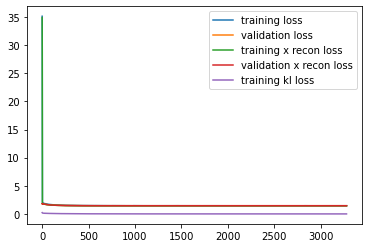

In [9]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_a_ep)
# plt.plot(np.arange(epochs),val_loss_a_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,20))
# plt.xlim((0,200))
plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [15]:
np.min(train_loss_clf_ep)


0.004286789335310459

In [13]:
# train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres

# adj_norm = preprocessing.preprocess_graph(adj_train)
# adj_label=adj_train + sp.eye(adj_train.shape[0])
# adj_label=torch.tensor(adj_label.todense())

# num_nodes,num_features = features.shape
# mse=torch.nn.MSELoss()

# model  = gae.gae.model.FCVAE1(num_features,hidden1, dropout)
# loss_x=optimizer.optimizer_MSE
# loss_a=optimizer.optimizer_CE
# pos_weight = float(adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) / adj_train.sum() #using full unmasked adj
# pos_weight=torch.tensor(pos_weight)
# norm = adj_train.shape[0] * adj_train.shape[0] / float((adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) * 2)

model.load_state_dict(torch.load(os.path.join(modelsavepath,str(440)+'.pt')))
model.eval()
# if use_cuda:
#     model.cuda()
#     features = features.cuda().float()
#     adj_norm=adj_norm.cuda()
#     adj_label = adj_label.cuda().float()
#     train_nodes_idx=train_nodes_idx.cuda()
#     val_nodes_idx=val_nodes_idx.cuda()
#     test_nodes_idx=test_nodes_idx.cuda()
# features_recon, z, mu, logvar=model(features)
adj_recon,mu,logvar, features_recon = model(features, adj_norm)
loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,mse)
loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx)
loss_test = loss_x_test+loss_a_test
print('test results',
      'loss_test: {:.4f}'.format(loss_test.item()),
      'loss_x_test: {:.4f}'.format(loss_x_test.item()),
      'loss_a_test: {:.4f}'.format(loss_a_test.item()))


test results loss_test: 99.6031 loss_x_test: 97.8105 loss_a_test: 1.7926


In [14]:
name='c13k20XA_08'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as output:
    loss=pickle.load(output)
np.min(loss)

69.8880386352539

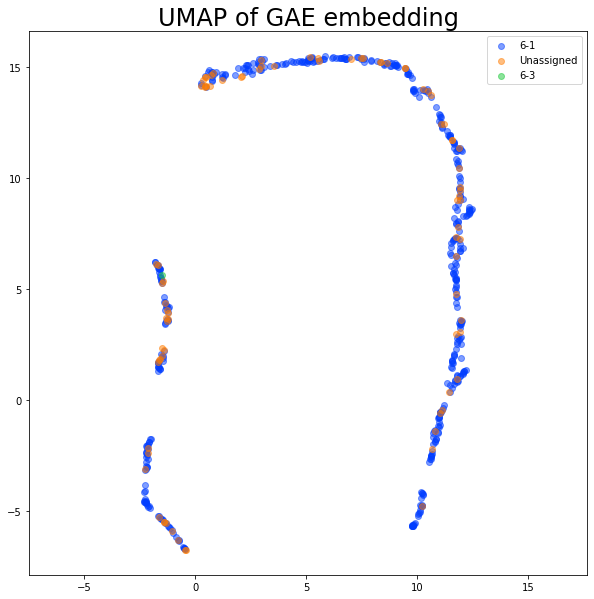

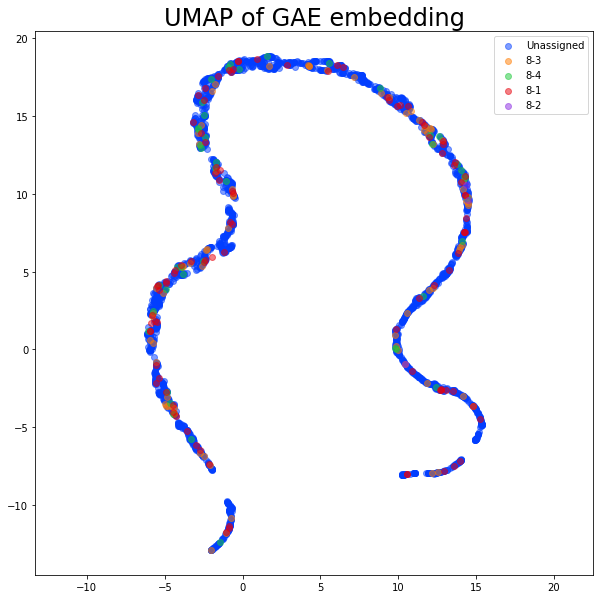

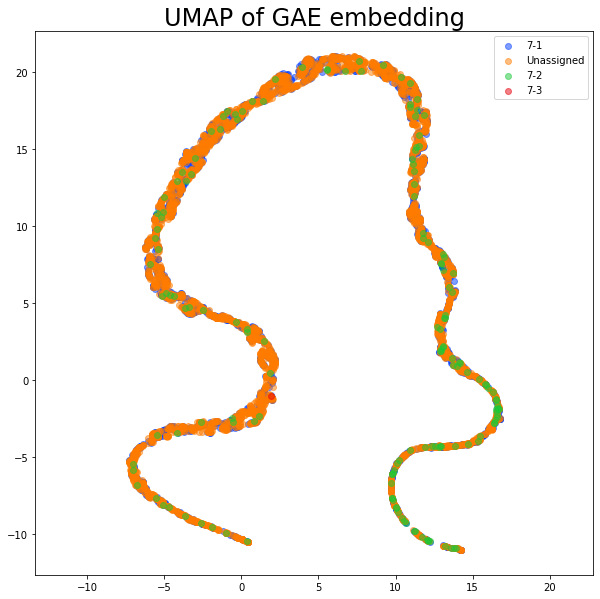

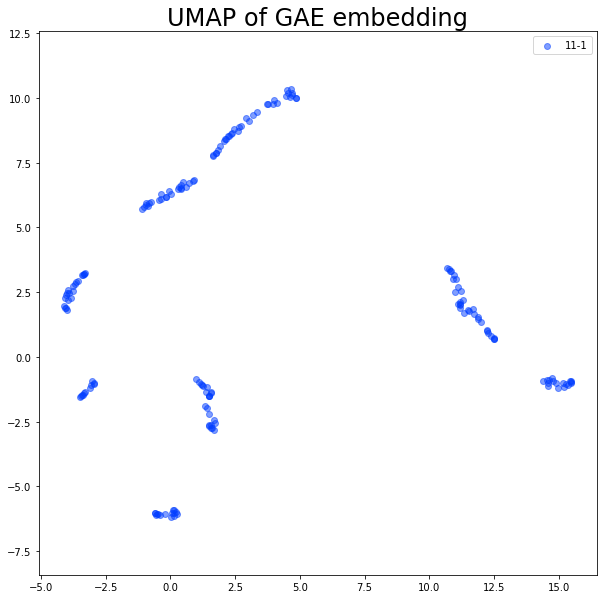

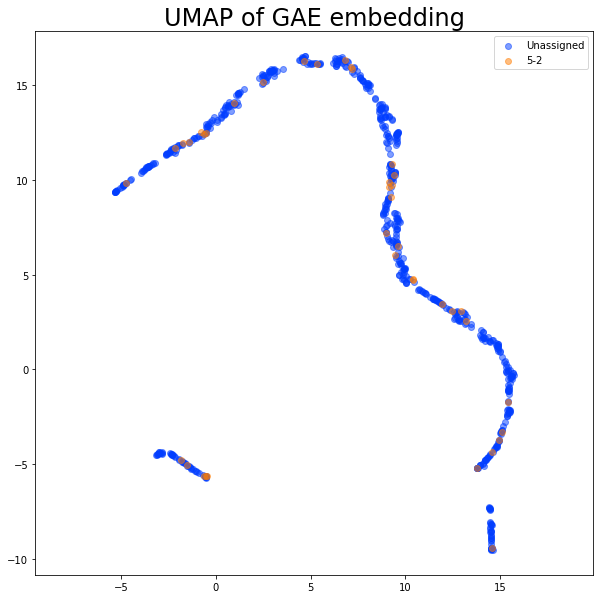

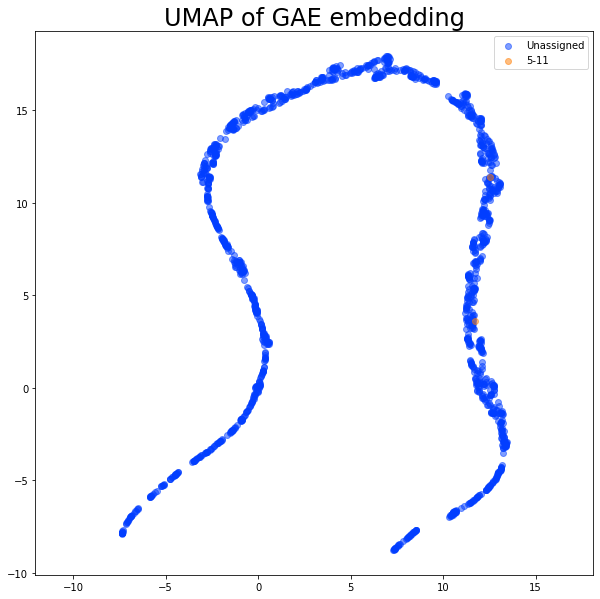

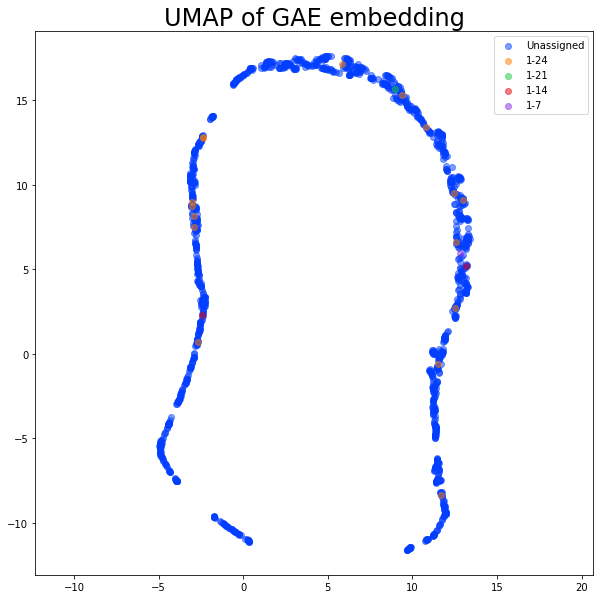

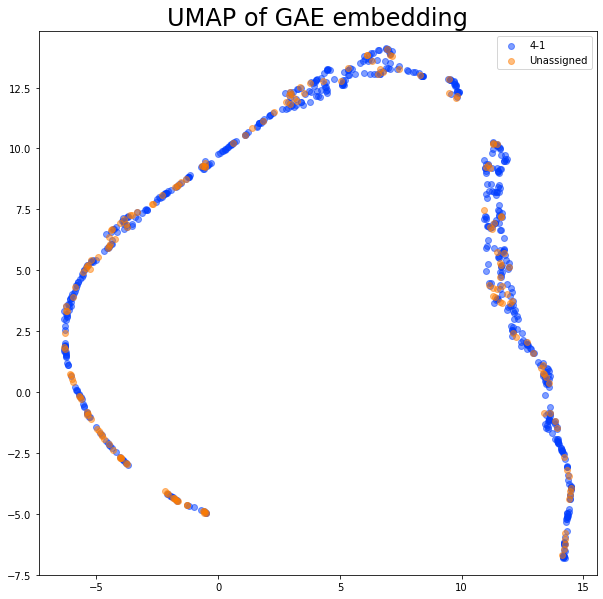

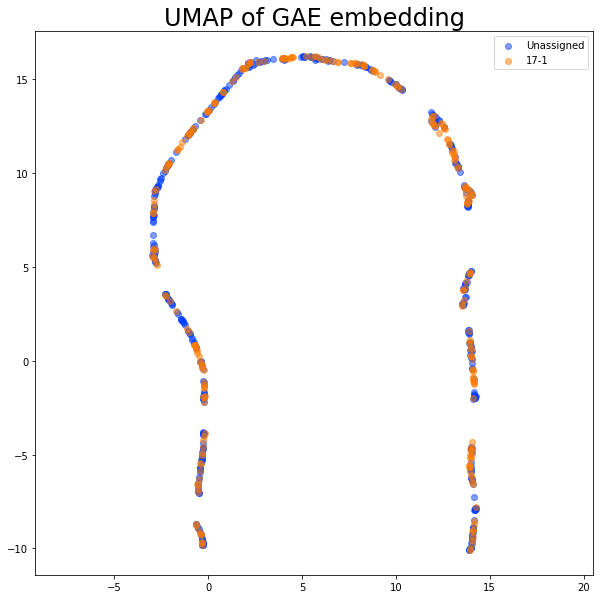

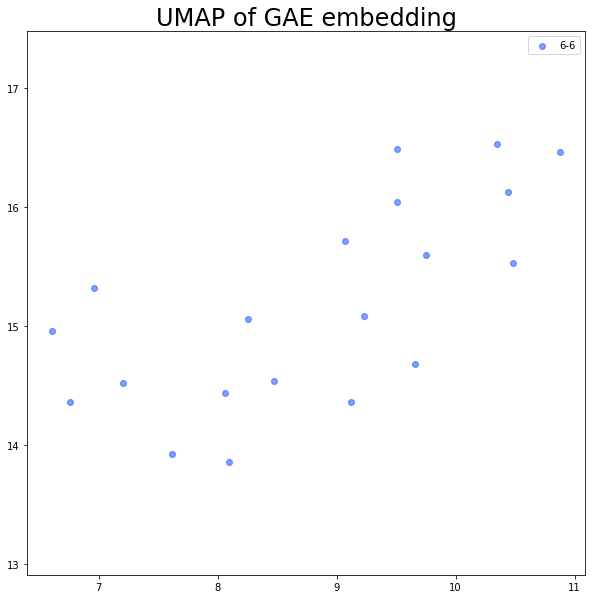

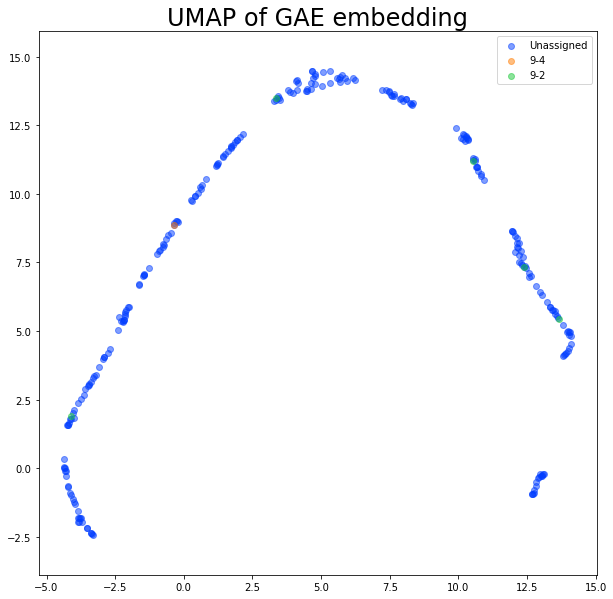

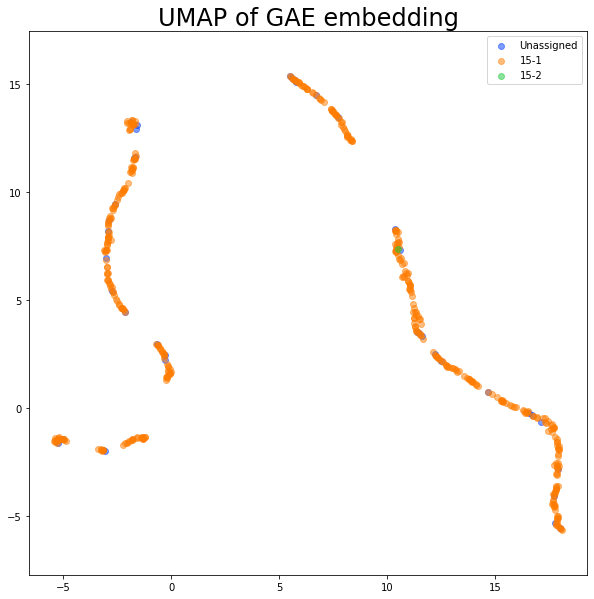

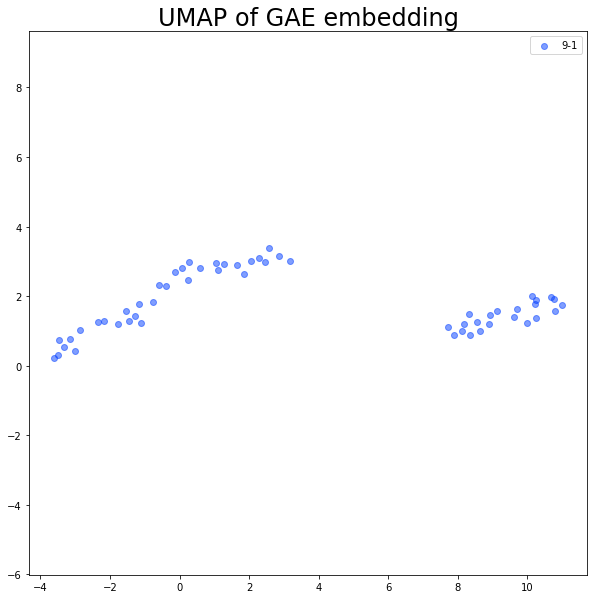

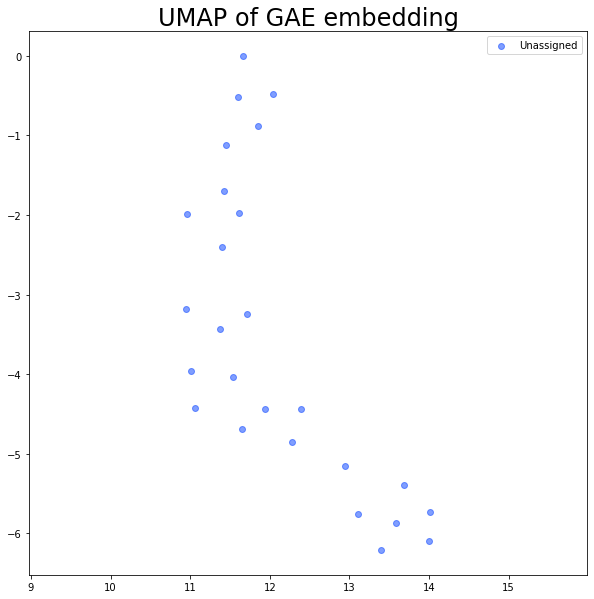

/home/xinyizxx/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1678: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


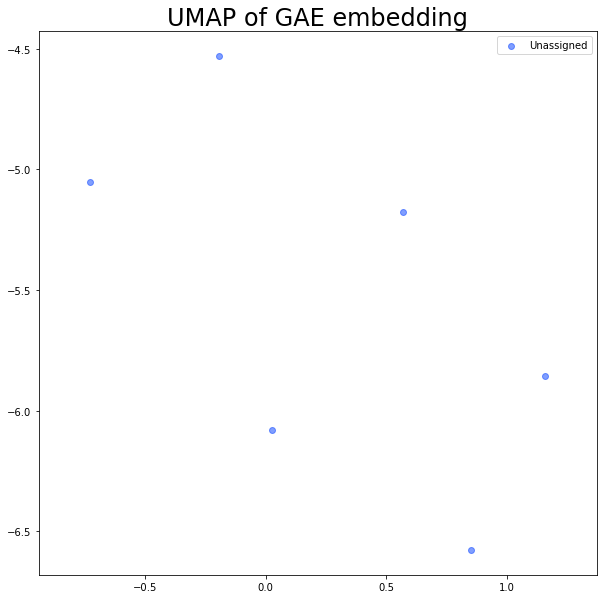

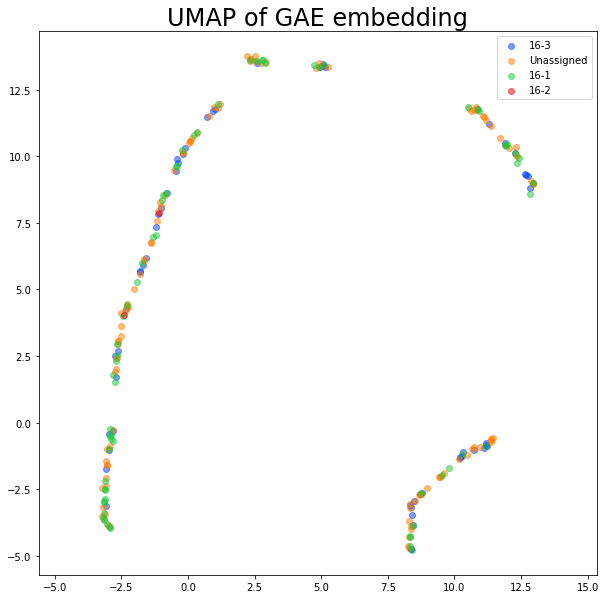

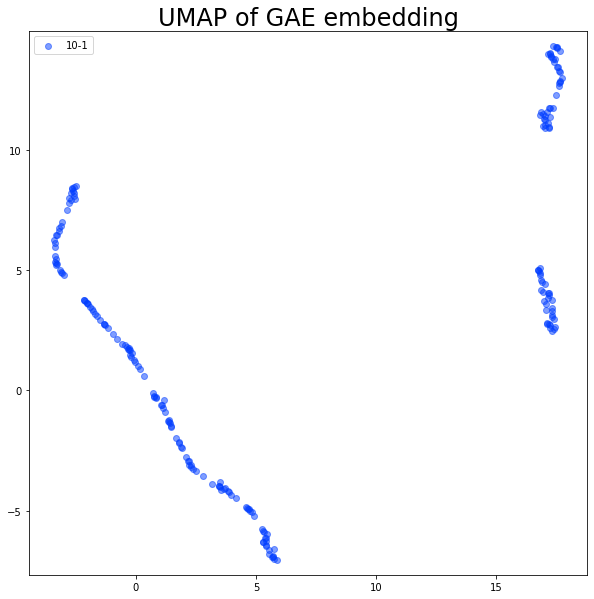

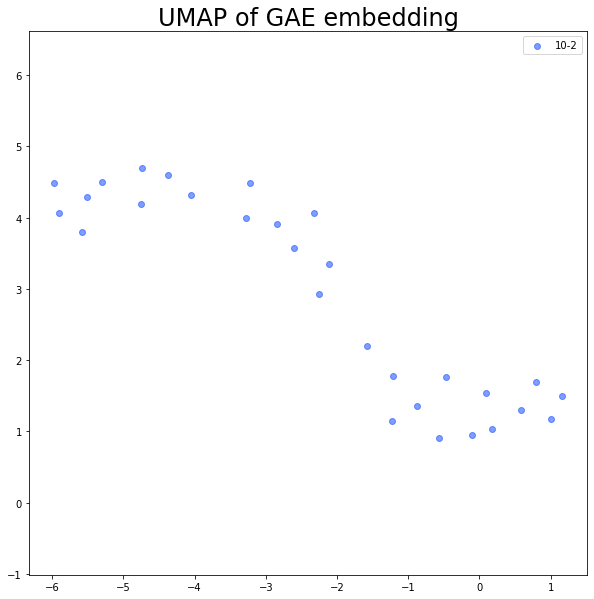

In [14]:
## TODO: modify for starmap##
if not os.path.exists('gae/plots/'+name+'/subclusters'):
    os.makedirs('gae/plots/'+name+'/subclusters')
    
colortest=sns.color_palette("bright")
colortest.extend(sns.color_palette("dark"))

for ct in celltypes:
    if ct == 'Unassigned':
        continue
        
    idx=f3000_celltype['V1']==ct
    emb_ct=mu.detach().numpy()
    emb_ct=emb_ct[idx,]
    
    reducer = umap.UMAP()
    umap_embedding_ct = reducer.fit_transform(emb_ct)
    
    fig, ax = plt.subplots()
    cidx=0
    for subct in f3000_subcluster.V1[idx].unique():
        idx_sub=f3000_subcluster['V1']==subct
        idx_sub=idx_sub[idx]
        ax.scatter(
            umap_embedding_ct[idx_sub, 0],
            umap_embedding_ct[idx_sub, 1],
            color=colortest[cidx],label=subct,alpha=0.5
            )
        cidx+=1

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.legend()
    plt.title('UMAP of GAE embedding', fontsize=24)
    plt.savefig('gae/plots/'+name+'/subclusters/seed3_umapCT_bysubcluster_'+ct+'.jpg')
    plt.show()



In [3]:
training_sample_X

NameError: name 'training_sample_X' is not defined